# Regridding data into Healpix

This notebook demonstrates a technique for converting unstructured data to the HEALPix grid. For additional information on the HEALpix grid, please visit https://healpy.readthedocs.io/en/latest/.

Author:
J.M. Delouis, LOPS-CNRS

In [1]:
#load needed libraries

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os
import xarray as xr

## Load the WW3 data

This notebook processes WW3 data retrieved from the web by regridding it. The following cell is employed to obtain the Hs data along with the corresponding longitude and latitude.

In [2]:
# URL of the NetCDF file
url = "https://data-ww3.ifremer.fr/FORECAST/NORGASUG/NORGAS-UG/FIELD_NC/best_estimate/2024/MARC_WW3-NORGAS-UG_20241211T20Z.nc"

local_file = "MARC_WW3-NORGAS-UG_20241211T20Z.nc"
try:
    # Open the dataset directly from the URL
    dataset = xr.open_dataset(local_file)
except:
    #local file has not been copy then download it
    # Download the file locally
    print("Downloading the file...")
    os.system('wget '+url)
    print(f"File downloaded to {local_file}")

    # Open the dataset directly from the URL
    dataset = xr.open_dataset(local_file)

# get the coordinate and the data to regrid
th = (90.0 - dataset["latitude"].as_numpy())/180.0*np.pi
ph = -dataset["longitude"].as_numpy()/180.0*np.pi
hs = np.array(dataset["hs"][0])

th=th[np.isfinite(hs)]
ph=ph[np.isfinite(hs)]
hs=hs[np.isfinite(hs)]
# Close the dataset
dataset.close()

# define the HEALPIX resolution

* nside= 512  ~12km, degree : resolution where all pixel has some values. It will be used to fill the gap of the nominal resolution.
* nside=2048  ~ 3km, degree : nominal resolution.

In [3]:
# Function that computes the regridding as the mean value of all data in a given pixel.

def regrid_healpix(nside, th, ph, val):
    
    # Step 1: Compute the HEALPix cell ID corresponding to the coordinates.
    heal_idx = hp.ang2pix(nside, th, ph)
    
    # Step 2: Accumulate the hit count and the signal sum in each pixel.
    map_hit = np.bincount(heal_idx, minlength=12 * nside**2)
    map = np.bincount(heal_idx, weights=val, minlength=12 * nside**2)

    # Step 3: Compute the mean for pixels that contain data.
    map[map_hit > 0] /= map_hit[map_hit > 0]
    map[map_hit == 0] = hp.UNSEEN
    return map


# compute the map at two different resolutions

map_512=regrid_healpix(512,th,ph,hs)
map_2048=regrid_healpix(2048,th,ph,hs)

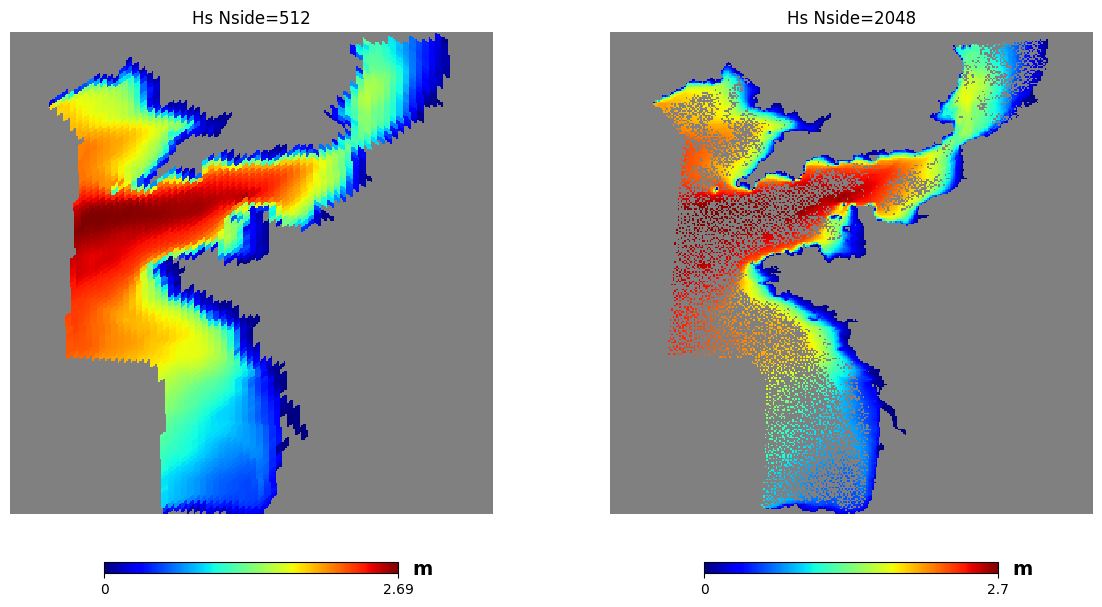

In [4]:
# plot the result

plt.figure(figsize=(12,6))
hp.gnomview(map_512,cmap='jet',rot=[2,48.3],reso=2,hold=False,sub=(1,2,1),
            title='Hs Nside=512',notext=True,unit='m',xsize=300,norm='hist')
hp.gnomview(map_2048,cmap='jet',rot=[2,48.3],reso=2,hold=False,sub=(1,2,2),
            title='Hs Nside=2048',notext=True,unit='m',xsize=300,norm='hist')

In [51]:
# get a map that provide the distance to the coast
nside=2048

try:
    mask=np.fromfile('continents_2048.npy',dtype='uint8')
except:
    #local file has not been copy then download it
    # Download the file locally
    print("Downloading the file...")
    os.system('wget https://github.com/jmdelouis/HealpixTools/blob/main/continents_2048.npy')
    print(f"File downloaded to continents_2048.npy")
    
    mask=np.fromfile('continents_2048.npy',dtype='uint8')
    
print(mask.shape)
mask = np.unpackbits(mask).astype(bool)
print(mask.shape,12*nside**2)

(292715,)
(2341720,) 50331648


In [52]:
tab=[128,256,512,1024,2048]
for itab in tab:
    im=hp.read_map('/home/jmdelouis/HealpixTools/dist_%d.fits'%(itab))
    # Créer un tableau de booléens
    bool_array = (1-np.isnan(im)).astype('bool')

    # Compresser le tableau en 1 bit par valeur
    compressed_array = np.packbits(bool_array)
    print(bool_array.shape,compressed_array.shape,compressed_array.dtype)

    compressed_array.tofile('/home/jmdelouis/HealpixTools/continents_%d.npy'%(itab))

(196608,) (24576,) uint8
(786432,) (98304,) uint8
(3145728,) (393216,) uint8
(12582912,) (1572864,) uint8
(50331648,) (6291456,) uint8


## Fill gap using lower resolution map

Owing to the dyadic nature of the HEALPix grid, determining the cell IDs for the nside=2048 resolution within the defined nside=512 resolution is straightforward. This process involves merely multiplying the indices of valid cell IDs at nside=512 by 16.

In [6]:
# Convert the valid cell IDs at nside=512 to nside=2048.
idx = hp.ring2nest(512, np.where(map_512 != hp.UNSEEN)[0])
idx = np.concatenate([idx * 4, idx * 4 + 1, idx * 4 + 2, idx * 4 + 3])  # 512 => 1024
idx = np.concatenate([idx * 4, idx * 4 + 1, idx * 4 + 2, idx * 4 + 3])  # 1024 => 2048
idx = hp.nest2ring(2048, idx)

# Compute the invalid pixels at nside=2048 that are valid at nside=512 and not on the coast.
l_idx = np.where((map_2048[idx] == hp.UNSEEN) * (mask[idx] > 0))[0]
idx = idx[l_idx]

# Compute the coordinates of those cell IDs.
t, p = hp.pix2ang(2048, idx)

# Build the interpolated values for those pixels.
imap = hp.get_interp_val(map_512, t, p)
imap[imap < 0] = hp.UNSEEN

# Add the values to the nside=2048 map.
map_2048[idx] = imap

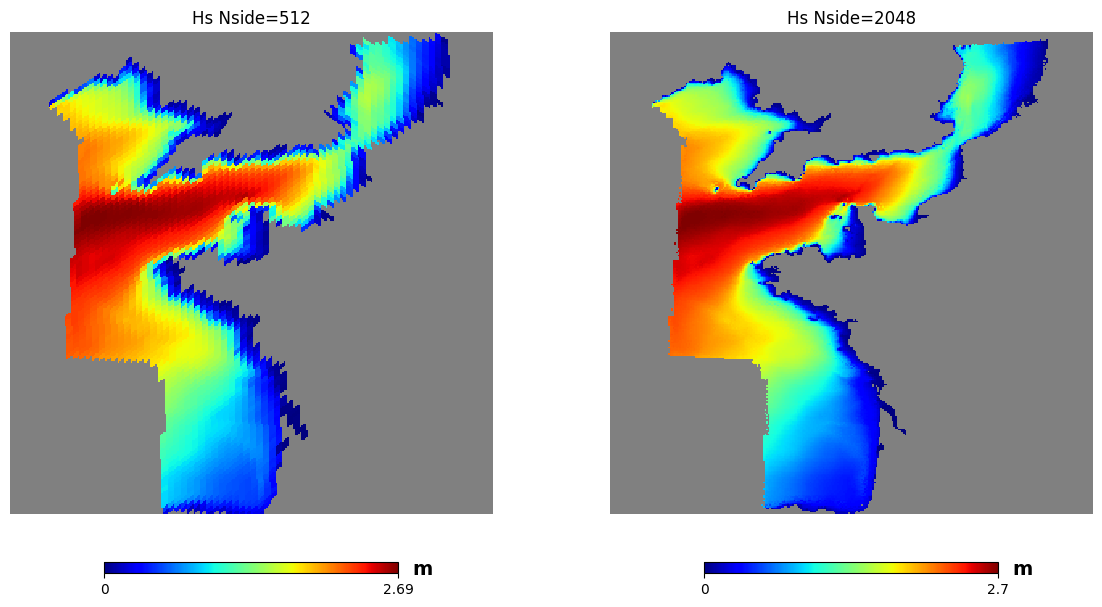

In [7]:
#plot the result

plt.figure(figsize=(12,6))
hp.gnomview(map_512,cmap='jet',rot=[2,48.3],reso=2,hold=False,sub=(1,2,1),
            title='Hs Nside=512',notext=True,unit='m',xsize=300,norm='hist')
hp.gnomview(map_2048,cmap='jet',rot=[2,48.3],reso=2,hold=False,sub=(1,2,2),
            title='Hs Nside=2048',notext=True,unit='m',xsize=300,norm='hist',min=0)